In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

# 1. Paths
data_path = 'breast augmented images'

# 2. Image Preprocessing
img_size = (224, 224)
batch_size = 16

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = datagen.flow_from_directory(
    data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

class_indices = train_gen.class_indices
class_names = list(class_indices.keys())
num_classes = len(class_names)
print(f"Detected {num_classes} classes: {class_names}")

# 3. Load Pretrained ResNet50 and Modify
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True  # Unfreeze all layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# 4. Compile
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 5. Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_gen.classes), y=train_gen.classes)
class_weights = dict(enumerate(class_weights))

# 6. Train
history = model.fit(
    train_gen,
    validation_data=val_gen,
    class_weight=class_weights,
    epochs=5,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
)

# 7. Evaluate
val_gen.reset()
pred_probs = model.predict(val_gen)
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = val_gen.classes

# 8. Metrics
acc = accuracy_score(true_labels, pred_labels)
prec = precision_score(true_labels, pred_labels, average='weighted')
rec = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')

print(f"\nAccuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1-score: {f1:.3f}")

try:
    roc = roc_auc_score(tf.keras.utils.to_categorical(true_labels), pred_probs, multi_class='ovr')
    print(f"ROC AUC: {roc:.3f}")
except Exception as e:
    print(f"ROC AUC not available: {e}")

print("\nClassification Report:\n", classification_report(true_labels, pred_labels, target_names=class_names))
print("Confusion Matrix:\n", confusion_matrix(true_labels, pred_labels))

# 9. Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(true_labels, pred_labels), annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 10. Accuracy Plot
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# 11. Loss Plot
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


Found 9600 images belonging to 3 classes.
Found 2400 images belonging to 3 classes.
Detected 3 classes: ['benign', 'malingnant', 'normal']


c:\Users\JARE WORKS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 1868s 3s/step - accuracy: 0.5987 - loss: 0.9315 - val_accuracy: 0.3350 - val_loss: 1.6195
Epoch 2/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 1858s 3s/step - accuracy: 0.7697 - loss: 0.5778 - val_accuracy: 0.5629 - val_loss: 0.9823
Epoch 3/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 1824s 3s/step - accuracy: 0.8026 - loss: 0.4891 - val_accuracy: 0.6021 - val_loss: 0.9840
Epoch 4/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 1824s 3s/step - accuracy: 0.8403 - loss: 0.4091 - val_accuracy: 0.5929 - val_loss: 1.5187
Epoch 5/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 1820s 3s/step - accuracy: 0.8608 - loss: 0.3487 - val_accuracy: 0.6058 - val_loss: 1.4007
Epoch 6/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 1817s 3s/step - accuracy: 0.8758 - loss: 0.3122 - val_accuracy: 0.6004 - val_loss: 1.3705
Epoch 7/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 1833s 3s/step - accuracy: 0.9009 - loss: 0.2597 - val_accuracy: 0.5854 - val_loss: 1.5601
Epoch 8/15
600/600 ━━━━━━━━━━━━━━━━━━━━ 1813s 3s/step - accuracy: 0.9114 - loss: 0.2449 - 

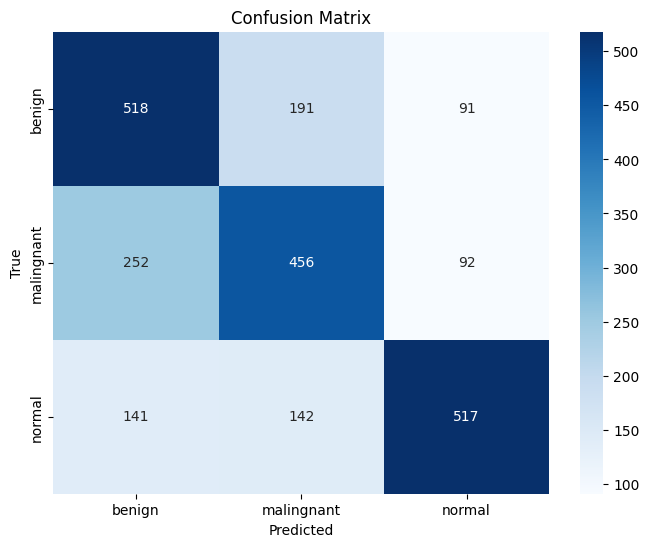

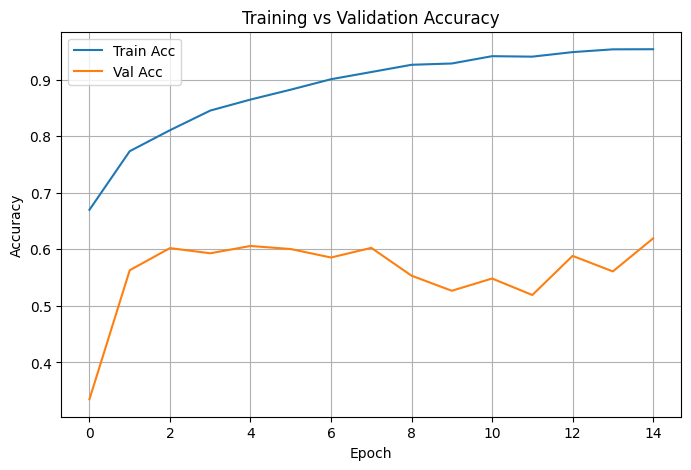

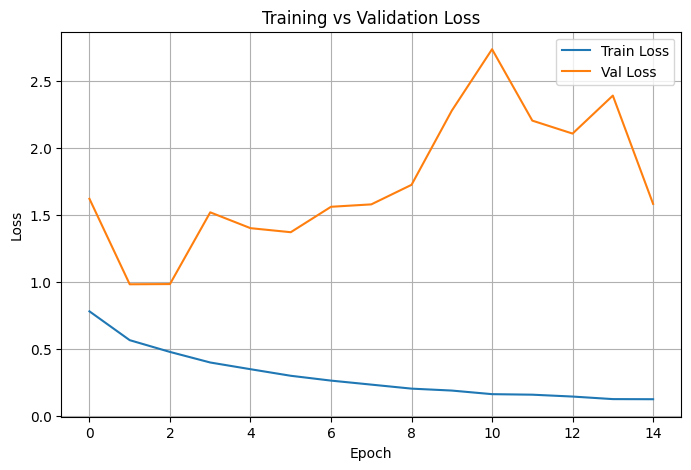

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

# 1. Paths
data_path = 'breast augmented images'

# 2. Image Preprocessing
img_size = (224, 224)
batch_size = 16

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = datagen.flow_from_directory(
    data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

class_indices = train_gen.class_indices
class_names = list(class_indices.keys())
num_classes = len(class_names)
print(f"Detected {num_classes} classes: {class_names}")

# 3. Load Pretrained ResNet50 and Modify
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze early layers
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# 4. Compile
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 5. Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_gen.classes), y=train_gen.classes)
class_weights = dict(enumerate(class_weights))

# 6. Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)

# 7. Train
history = model.fit(
    train_gen,
    validation_data=val_gen,
    class_weight=class_weights,
    epochs=30,
    callbacks=[reduce_lr, early_stop]
)

# 8. Evaluate
val_gen.reset()
pred_probs = model.predict(val_gen)
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = val_gen.classes

# 9. Metrics
acc = accuracy_score(true_labels, pred_labels)
prec = precision_score(true_labels, pred_labels, average='weighted')
rec = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')

print(f"\nAccuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1-score: {f1:.3f}")

try:
    roc = roc_auc_score(tf.keras.utils.to_categorical(true_labels), pred_probs, multi_class='ovr')
    print(f"ROC AUC: {roc:.3f}")
except Exception as e:
    print(f"ROC AUC not available: {e}")

print("\nClassification Report:\n", classification_report(true_labels, pred_labels, target_names=class_names))
print("Confusion Matrix:\n", confusion_matrix(true_labels, pred_labels))

# 10. Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(true_labels, pred_labels), annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 11. Accuracy Plot
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# 12. Loss Plot
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


Found 9600 images belonging to 3 classes.
Found 2400 images belonging to 3 classes.
Detected 3 classes: ['benign', 'malingnant', 'normal']


c:\Users\JARE WORKS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 898s 1s/step - accuracy: 0.4400 - loss: 1.2637 - val_accuracy: 0.3338 - val_loss: 2.8754 - learning_rate: 1.0000e-04
Epoch 2/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 816s 1s/step - accuracy: 0.5003 - loss: 1.0722 - val_accuracy: 0.3333 - val_loss: 5.1466 - learning_rate: 1.0000e-04
Epoch 3/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 791s 1s/step - accuracy: 0.5040 - loss: 1.0315 - val_accuracy: 0.3487 - val_loss: 2.4001 - learning_rate: 1.0000e-04
Epoch 4/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 797s 1s/step - accuracy: 0.5207 - loss: 1.0138 - val_accuracy: 0.3392 - val_loss: 1.9979 - learning_rate: 1.0000e-04
Epoch 5/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 828s 1s/step - accuracy: 0.5185 - loss: 1.0032 - val_accuracy: 0.3383 - val_loss: 1.9042 - learning_rate: 1.0000e-04
Epoch 6/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 743s 1s/step - accuracy: 0.5392 - loss: 0.9797 - val_accuracy: 0.3333 - val_loss: 4.2716 - learning_rate: 1.0000e-04
Epoch 7/10
600/600 ━━━━━━━━━━━━━━━━━━━━ 752s 1s/step - acc

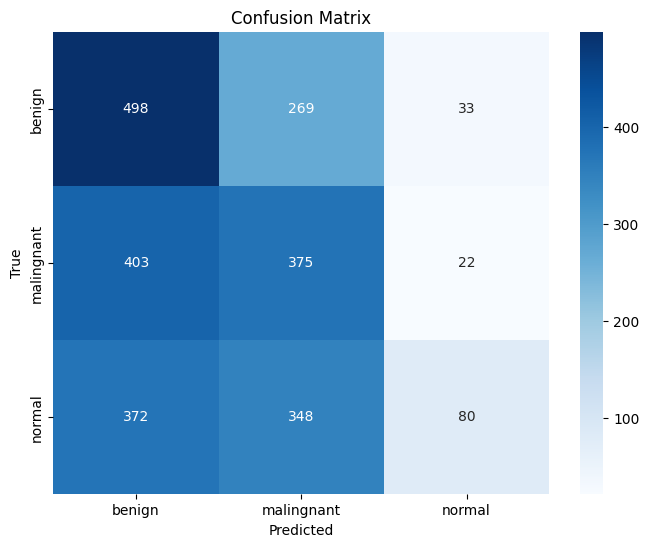

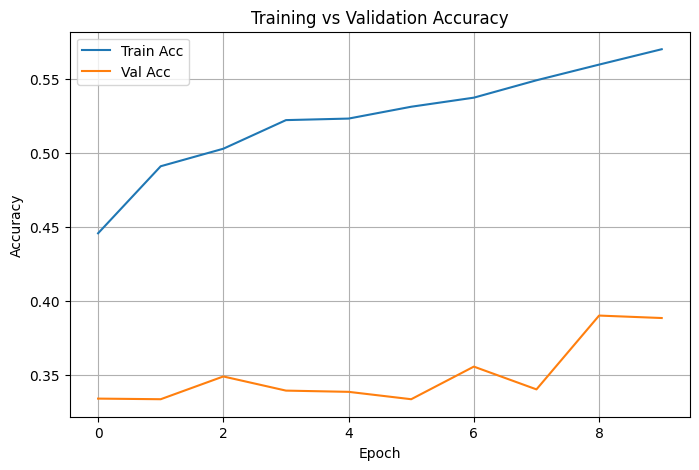

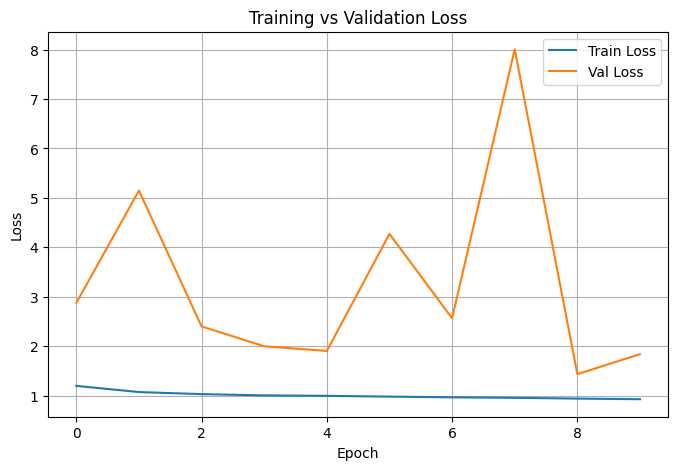

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

# 1. Paths
data_path = 'breast augmented images'

# 2. Image Preprocessing
img_size = (224, 224)
batch_size = 16

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = datagen.flow_from_directory(
    data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

class_indices = train_gen.class_indices
class_names = list(class_indices.keys())
num_classes = len(class_names)
print(f"Detected {num_classes} classes: {class_names}")

# 3. Load Pretrained ResNet50 and Modify
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze early layers
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# 4. Compile
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 5. Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_gen.classes), y=train_gen.classes)
class_weights = dict(enumerate(class_weights))

# 6. Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)

# 7. Train
history = model.fit(
    train_gen,
    validation_data=val_gen,
    class_weight=class_weights,
    epochs=10,
    callbacks=[reduce_lr, early_stop]
)

# 8. Evaluate
val_gen.reset()
pred_probs = model.predict(val_gen)
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = val_gen.classes

# 9. Metrics
acc = accuracy_score(true_labels, pred_labels)
prec = precision_score(true_labels, pred_labels, average='weighted')
rec = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')

print(f"\nAccuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1-score: {f1:.3f}")

try:
    roc = roc_auc_score(tf.keras.utils.to_categorical(true_labels), pred_probs, multi_class='ovr')
    print(f"ROC AUC: {roc:.3f}")
except Exception as e:
    print(f"ROC AUC not available: {e}")

print("\nClassification Report:\n", classification_report(true_labels, pred_labels, target_names=class_names))
print("Confusion Matrix:\n", confusion_matrix(true_labels, pred_labels))

# 10. Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(true_labels, pred_labels), annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 11. Accuracy Plot
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# 12. Loss Plot
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


Found 9600 images belonging to 3 classes.
Found 2400 images belonging to 3 classes.
Detected 3 classes: ['benign', 'malingnant', 'normal']


c:\Users\JARE WORKS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 738s 1s/step - accuracy: 0.4332 - loss: 1.2877 - val_accuracy: 0.3333 - val_loss: 2.0216 - learning_rate: 1.0000e-04
Epoch 2/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 775s 1s/step - accuracy: 0.4773 - loss: 1.0879 - val_accuracy: 0.3333 - val_loss: 2.5026 - learning_rate: 1.0000e-04
Epoch 3/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 780s 1s/step - accuracy: 0.5102 - loss: 1.0341 - val_accuracy: 0.3587 - val_loss: 1.6971 - learning_rate: 1.0000e-04
Epoch 4/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 770s 1s/step - accuracy: 0.5020 - loss: 1.0257 - val_accuracy: 0.3283 - val_loss: 2.7864 - learning_rate: 1.0000e-04
Epoch 5/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 873s 1s/step - accuracy: 0.5289 - loss: 0.9939 - val_accuracy: 0.3333 - val_loss: 6.9204 - learning_rate: 1.0000e-04
Epoch 6/30
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5273 - loss: 0.9818
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
600/600 ━━━━━━━━━━━━━━━━━━━━ 808s 1s/step - accuracy:

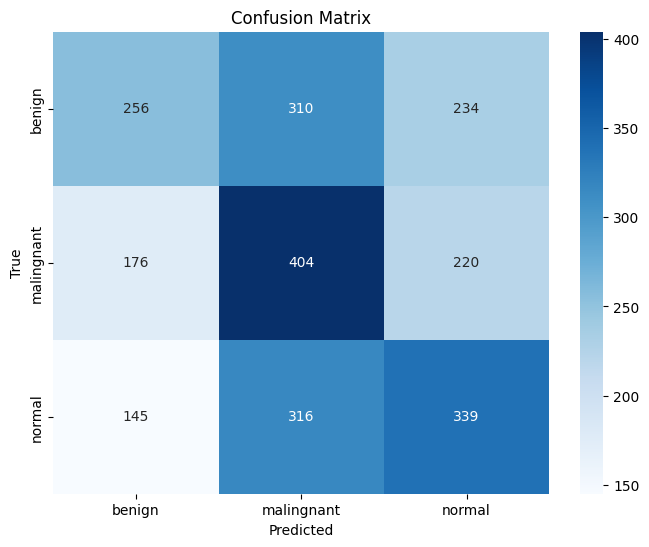

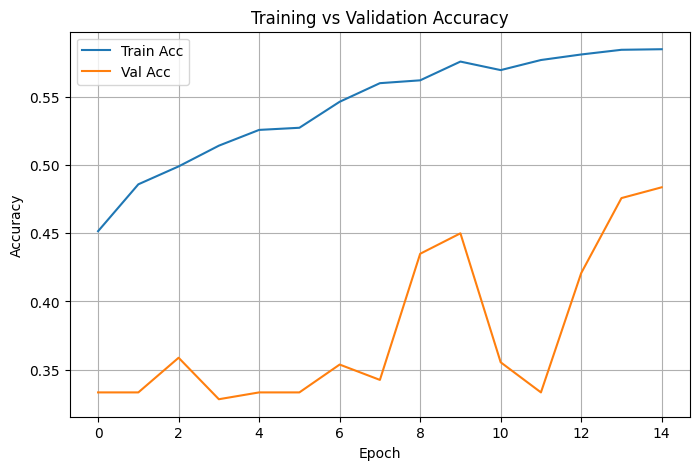

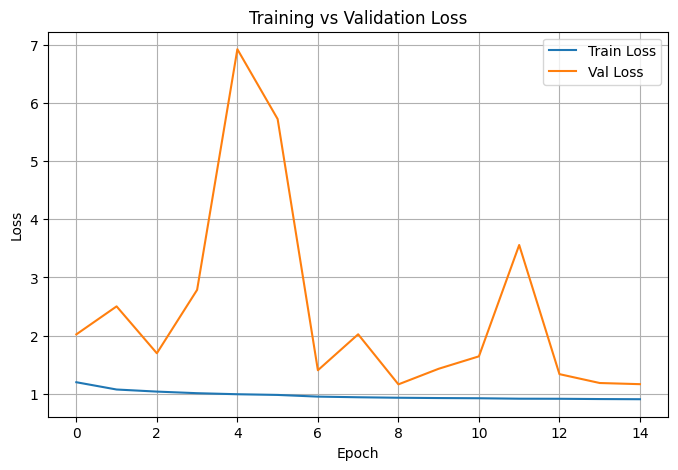

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

# 1. Paths
data_path = 'breast augmented images'

# 2. Image Preprocessing
img_size = (224, 224)
batch_size = 16

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = datagen.flow_from_directory(
    data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

class_indices = train_gen.class_indices
class_names = list(class_indices.keys())
num_classes = len(class_names)
print(f"Detected {num_classes} classes: {class_names}")

# 3. Load Pretrained ResNet50 and Modify
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze early layers
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# 4. Compile
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 5. Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_gen.classes), y=train_gen.classes)
class_weights = dict(enumerate(class_weights))

# 6. Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)

# 7. Train
history = model.fit(
    train_gen,
    validation_data=val_gen,
    class_weight=class_weights,
    epochs=30,
    callbacks=[reduce_lr, early_stop]
)

# 8. Evaluate
val_gen.reset()
pred_probs = model.predict(val_gen)
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = val_gen.classes

# 9. Metrics
acc = accuracy_score(true_labels, pred_labels)
prec = precision_score(true_labels, pred_labels, average='weighted')
rec = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')

print(f"\nAccuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1-score: {f1:.3f}")

try:
    roc = roc_auc_score(tf.keras.utils.to_categorical(true_labels), pred_probs, multi_class='ovr')
    print(f"ROC AUC: {roc:.3f}")
except Exception as e:
    print(f"ROC AUC not available: {e}")

print("\nClassification Report:\n", classification_report(true_labels, pred_labels, target_names=class_names))
print("Confusion Matrix:\n", confusion_matrix(true_labels, pred_labels))

# 10. Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(true_labels, pred_labels), annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 11. Accuracy Plot
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# 12. Loss Plot
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()
